In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import time
import numpy as np
import matplotlib.ticker as mticker
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.lines import Line2D
import scipy.stats as stats
from scipy.stats import kurtosis, skew,jarque_bera, f_oneway

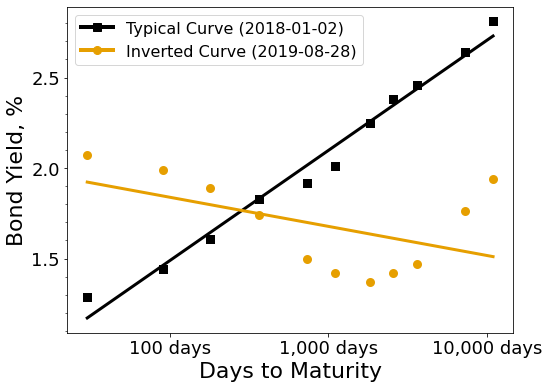

In [2]:
# Load the bonds
bonds = pd.read_csv('Bond_Yields.csv')

# Select interested dates
bonds.Date = pd.to_datetime(bonds['Date'])
all_months = ['2019-08-28','2018-01-02']
all_months = pd.to_datetime(all_months)
b = bonds.loc[bonds.Date == all_months[0]]
c = bonds.loc[bonds.Date == all_months[1]]

# Make a plot
fig, axs = plt.subplots(1, 1,figsize=(8,6))

# Pop columns with null data 
x_1 = list(b.columns)
x_1.pop(0)
x_1.pop(1)

# Get the associated values
all_tweets_1 = []
all_tweets_2 = []

for i in range(len(x_1)):
    all_tweets_1.append(b[x_1[i]].mean())
    all_tweets_2.append(c[x_1[i]].mean())
    #all_e.append(mean_confidence_interval(b[x_1[i]]))

# Get a list of x    
x = [30,90,180,365,730,1095,1825,2555,3650,7300,10950]
x = [np.log10(y) for y in x]
x_poly = []
for m in range(len(x)-1):
    if m == 0:
        x_a = 0
    else:
        x_a = x[m-1]
    x_b = x[m]
    for n in [.2,.4,.6,.8,1]:
        x_poly.append(x_a + (x_b - x_a) * n)
      
coef = np.polyfit(x,all_tweets_2,1)
poly1d_fn = np.poly1d(coef) 
axs.plot(x, all_tweets_2, marker='s', color = "black",linestyle='None',mew=3)
axs.plot(x, poly1d_fn(x), '-',color='black',lw=3)
        
coef = np.polyfit(x,all_tweets_1,1)
poly1d_fn = np.poly1d(coef) 
axs.plot(x, all_tweets_1, marker='o', color = "#E69F00",linestyle='None',mew=3)
axs.plot(x, poly1d_fn(x), '-',color='#E69F00',lw=3)


axs.set_ylabel("Bond Yield, %", fontsize = 22)
axs.set_xlabel("Days to Maturity", fontsize = 22)
custom_lines = [Line2D([0], [0], color='black',  lw=4, marker='s',ms=8),
                Line2D([0], [0], color='#E69F00', lw=4, marker='o',ms=8)]
axs.legend(custom_lines,["Typical Curve ("+str(all_months[1])[:10]+')',"Inverted Curve ("+str(all_months[0])[:10]+')'],fontsize = 16)
axs.tick_params(labelsize=18)
axs.yaxis.set_major_locator(mticker.MultipleLocator(0.5))
axs.yaxis.set_minor_locator(mticker.MultipleLocator(0.1))
axs.xaxis.set_major_locator(mticker.MultipleLocator(1))
axs.set_xticklabels(('','100 days','1,000 days','10,000 days'))


plt.savefig("plots/Treasury-Bond_Yield-Curve.png",dpi=400)
plt.show()

In [3]:
df_bot_accounts = pd.read_csv('data/bots.csv')
all_phrases = ['2 days','3 days','4 days','5 days','7 days','10 days',
               '2 weeks','3 weeks','4 weeks','6 weeks',
              '2 months','3 months','4 months','5 months','6 months','12 months',
              '2 years','3 years','4 years','5 years','10 years','20 years','30 years']

# Read all of the filenames
all_sents = [f for f in listdir('data/VADER/') if isfile(join('data/VADER/', f))]
all_sents = ["data/VADER/"+f for f in all_sents if f[len(f)-4:]== ".csv"]


var = 'vader'
df = pd.read_csv(all_sents[0])
df['phrase'] = all_sents[0][11:all_sents[0].index('_t')]
df = df[['tweet_id','created_at','phrase',var]]

for i in all_sents[1:]:
    df_1 = pd.read_csv(i)
    df_1['phrase'] = i[11:i.index('_t')]

    df_1 = df_1[['tweet_id','created_at','phrase',var]]
    df = pd.concat([df,df_1])

df = df.drop_duplicates()
df = df.loc[df.vader!=0]
df.created_at = pd.to_datetime(df['created_at'])
df = df.dropna(subset=[var])
df = df.loc[~df.tweet_id.isin(list(df_bot_accounts.tweet_id))]


In [4]:
# Helper function to load a specific month
def get_range(t_1,t_2):
    
    df_range = df.copy()
    df_range.created_at = pd.to_datetime(df_range['created_at'])
    # Select only tweets in these dates
    mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df_range['created_at']) & (df_range['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
    df_range = df_range.loc[mask]

    return df_range

# Helper function for confidence intervals
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2, n-1)
    return h

# Helper function to get the counts of all dates
def get_counts():
    df_counts = pd.DataFrame({'created_at':[],'count':[], 'phrase':[]})

    # For each file
    for f in all_sents:

        # Read in a file
        df_temp = pd.read_csv(f)

        # Remove 0 sentiment:
        df_temp = df_temp.loc[df_temp['Sentiment'] != 0]
        
        # Drop duplicates if they exist
        df_temp = df_temp.drop_duplicates()
        
        # Get the phrase
        phrase = df_temp.phrase.values[0]

        # Change to date-time and group by date
        s = pd.to_datetime(df_temp['created_at'])
        df_temp = s.groupby(s.dt.floor('d')).size().reset_index(name='count')
        df_temp['phrase'] = phrase
        
        df_counts = pd.concat([df_counts,df_temp])
    
    return df_counts

# Helper function to get log x values
def get_x():
    x_1 = [2,3,4,5,7,10,14,21,28,42,60,90,120,150,180,365,730,3*365,4*365,5*365,10*365,20*365,30*365]
    x = [np.log10(n) for n in x_1]  
    return(x)

In [5]:
t_1 = "2017-08-01"
t_2 = "2020-03-11"
t_3 = "2020-04-11"
all_phrases = ['2-days','3-days','4-days','5-days','7-days','10-days',
               '2-weeks','3-weeks','4-weeks','6-weeks',
              '2-months','3-months','4-months','5-months','6-months','12-months',
              '2-years','3-years','4-years','5-years','10-years','20-years','30-years']

x = get_x()
df_cor = df.loc[df.phrase == all_phrases[0]]
df_cor['x'] = x[0]
for i in range(len(all_phrases)-1):
    df_temp =df.loc[df.phrase == all_phrases[i+1]]
    df_temp['x'] = x[i+1]
    df_cor = pd.concat([df_cor,df_temp])

df_temp = df_cor.copy()
mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df_temp['created_at']) & (df_temp['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
df_temp = df_temp.loc[mask]
print(stats.pearsonr(df_temp.vader,df_temp.x))

df_temp = df_cor.copy()
mask = (pd.Timestamp(t_2+' 00:00:00+0000') <= df_temp['created_at']) & (df_temp['created_at'] < pd.Timestamp(t_3+' 00:00:00+0000'))
df_temp = df_temp.loc[mask]
print(stats.pearsonr(df_temp.vader,df_temp.x))

/Users/calvinisch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/calvinisch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(-0.05946789152283587, 0.0)
(0.01591252178615337, 2.7138141256422185e-05)


 
-0.03125 x + 0.2273
 
0.007065 x + 0.08596


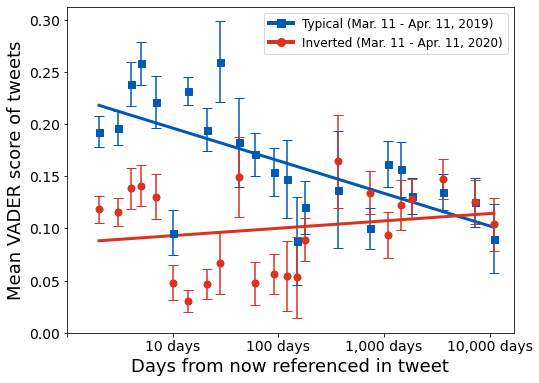

In [6]:
# Plot March 2019 and 2020
fig, axs = plt.subplots(1, 1,figsize=(8,6))

# Get all phrases and x locations in log of days
x = get_x()
all_phrases = ['2-days','3-days','4-days','5-days','7-days','10-days',
               '2-weeks','3-weeks','4-weeks','6-weeks',
              '2-months','3-months','4-months','5-months','6-months','12-months',
              '2-years','3-years','4-years','5-years','10-years','20-years','30-years']

# Plot 2019
df_main = get_range("2019-03-11", "2019-04-11") # 2018-03
all_tweets = [df_main.loc[df_main['phrase'] == phrase][var].mean() for phrase in all_phrases]
all_e = [mean_confidence_interval(df_main.loc[df_main['phrase'] == phrase][var]) for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef) 
print(poly1d_fn)
axs.errorbar(x, all_tweets, all_e, linestyle='None', marker='s', ecolor="#005AB5", mec="#005AB5", mfc="#005AB5", mew=1, ms=7, capsize=5)
axs.plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color="#005AB5",lw=3)


# Plot 2020
df_main = get_range("2020-03-11", "2020-04-11") #2020 - 03-11
all_tweets = [df_main.loc[df_main['phrase'] == phrase][var].mean() for phrase in all_phrases]
all_e = [mean_confidence_interval(df_main.loc[df_main['phrase'] == phrase][var]) for phrase in all_phrases]
coef = np.polyfit(x,all_tweets,1)
poly1d_fn = np.poly1d(coef) 
print(poly1d_fn)
axs.errorbar(x, all_tweets, all_e, linestyle='None', marker='o', ecolor="#DC3220", mec="#DC3220", mfc="#DC3220", mew=1, ms=7, capsize=5)
axs.plot(x, all_tweets, 'yo', x, poly1d_fn(x), '-k',color="#DC3220",lw=3)

# Labels
plt.ylabel('Mean VADER score of tweets', fontsize = 18)
plt.xlabel("Days from now referenced in tweet", fontsize = 18)

custom_lines = [Line2D([0], [0], color='#005AB5',  lw=4, marker='s',ms=8),
                Line2D([0], [0], color='#DC3220', lw=4,  marker='o',ms=8)]

axs.legend(custom_lines,["Typical (Mar. 11 - Apr. 11, 2019)","Inverted (Mar. 11 - Apr. 11, 2020)"],fontsize = 12)
plt.xticks(np.arange(5), ('','10 days', '100 days','1,000 days','10,000 days'))
axs.tick_params(labelsize=14)
plt.savefig('plots/Sentiment-Yield-Curve-Typical-Inverted-new.png',dpi=400)
plt.show()


In [7]:
all_months = ["2017-08-01","2017-09-01","2017-10-01","2017-11-01","2017-12-01",
             "2018-01-01","2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01",
             "2018-07-01","2018-08-01","2018-09-01","2018-10-01","2018-11-01","2018-12-01",
             "2019-01-01","2019-02-01","2019-03-01","2019-04-01","2019-05-01","2019-06-01",
             "2019-07-01","2019-08-01","2019-09-01","2019-10-01","2019-11-01","2019-12-01",
             "2020-01-01","2020-02-01","2020-03-01","2020-04-01","2020-05-01","2020-06-01",
             "2020-07-01","2020-08-01","2020-09-01","2020-10-01","2020-11-01"]

x = get_x()
all_curves = []
all_means = []
for i in range(len(all_months)-1):
    t_1 = all_months[i]
    t_2 = all_months[i+1]

    mask = (pd.Timestamp(t_1+' 00:00:00+0000') <= df['created_at']) & (df['created_at'] < pd.Timestamp(t_2+' 00:00:00+0000'))
    df_main = df.loc[mask]
    all_means.append(df_main["vader"].mean())

    all_tweets = [df_main.loc[df_main['phrase'] == phrase]["vader"].mean() for phrase in all_phrases]
    coef = np.polyfit(x,all_tweets,1)
    all_curves.append(coef[0])

    
df_curves = pd.DataFrame({'months':all_months[:len(all_months)-1],'curve':all_curves[:],'means':all_means[:]})


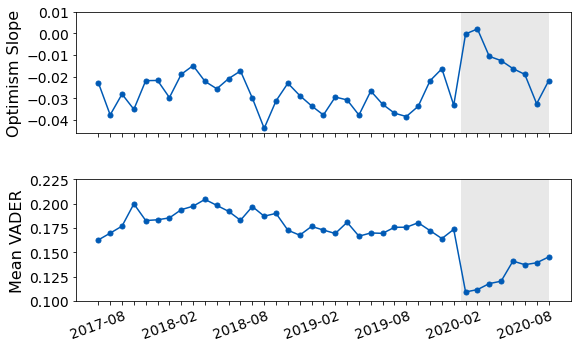

In [8]:
fig, axs = plt.subplots(2, 1,figsize=(8,5))
fig.tight_layout(pad=2.5)

axs[0].plot(df_curves['months'],df_curves['curve'],marker='o',markersize=5,color='#005AB5')
axs[0].set_ylabel('Optimism Slope',fontsize=16)
axs[0].axvspan(30.6, 38, facecolor="#D3D3D3", alpha=0.5)
axs[0].set_xticks(np.arange(39))
axs[0].set_yticks([-.04,-.03,-.02,-.01,0,.01])
axs[0].tick_params(labelsize=14)
axs[0].set_xticklabels(['',"","",'',"","",'',"","",
                          '',"","",'',"","",'',"","",
                          '',"","",'',"","",'',"","",
                          '',"","",'',"","",'',"","",""])

axs[1].plot(df_curves['months'],df_curves['means'],marker='o',markersize=5,color='#005AB5')
axs[1].set_ylabel('Mean VADER',fontsize=16)
axs[1].set_xticks(np.arange(39))
axs[1].set_yticks([.1,.125,.15,.175,.2,.225])
axs[1].tick_params(labelsize=14)
axs[1].axvspan(30.6, 38, facecolor="#D3D3D3", alpha=0.5)
axs[1].set_xticklabels(['2017-08',"","",'',"","",'2018-02',"","",
                          '',"","",'2018-08',"","",'',"","",
                          '2019-02',"","",'',"","",'2019-08',"","",
                          '',"","",'2020-02',"","",'',"","",'2020-08',""],rotation = 20)
#plt.savefig("plots/regular-sentiment-over-time.png",dpi=400)
plt.show()

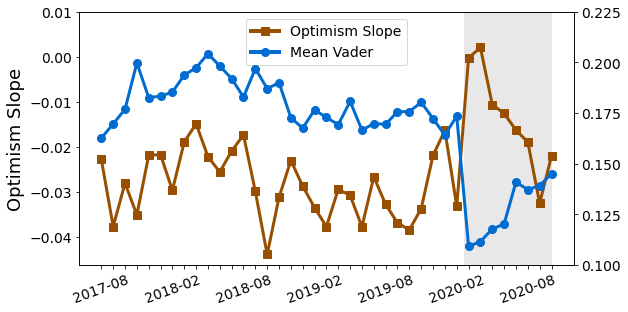

In [9]:
fig, axs = plt.subplots(1, 1,figsize=(8,4.5))
fig.tight_layout(pad=2.5)

axs.axvspan(30.6, 38, facecolor="#D3D3D3", alpha=0.5)
axs.plot(df_curves['months'],df_curves['curve'],marker='s',lw=3,markersize=8,color='#994F00')
axs.set_ylabel('Optimism Slope',fontsize=18)
axs.tick_params(labelsize=14)
axs.set_xticks(np.arange(39))
axs.set_yticks([-.04,-.03,-.02,-.01,0,.01])
axs.set_xticklabels(['2017-08',"","",'',"","",'2018-02',"","",
                          '',"","",'2018-08',"","",'',"","",
                          '2019-02',"","",'',"","",'2019-08',"","",
                          '',"","",'2020-02',"","",'',"","",'2020-08',""],rotation = 20)

ax2 = axs.twinx()
ax2.plot(df_curves['months'],df_curves['means'],marker='o',lw=3,markersize=8,color='#006CD1')
#ax2.set_ylabel('Mean VADER',fontsize=16,rotation=270)
ax2.set_xticks(np.arange(39))
ax2.set_yticks([.1,.125,.15,.175,.2,.225])
ax2.tick_params(labelsize=14)

axs.set_xticklabels(['2017-08',"","",'',"","",'2018-02',"","",
                          '',"","",'2018-08',"","",'',"","",
                          '2019-02',"","",'',"","",'2019-08',"","",
                          '',"","",'2020-02',"","",'',"","",'2020-08',""],rotation = 20)
custom_lines = [Line2D([0], [0], color='#994F00',  lw=4, marker='s',ms=8),
                Line2D([0], [0], color='#006CD1', lw=4,  marker='o',ms=8)]

axs.legend(custom_lines,["Optimism Slope","Mean Vader"],fontsize = 14,loc='upper center')


plt.savefig("plots/regular-sentiment-over-time-new.png",dpi=400,bbox_inches='tight')
plt.show()

39 39 39


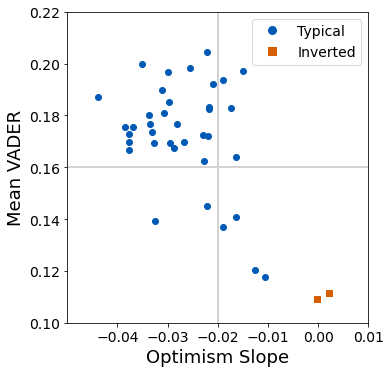

In [10]:
fig, axs = plt.subplots(1, 1,figsize=(6,6))
plt.tight_layout(pad = 5)
axs.plot([-.02, -.02], [.1, .22], '-', color = '#d3d3d3', lw=2)
axs.plot([-.05, .02], [.16, .16], '-', color = '#d3d3d3', lw=2)

linear_rels = list(df_curves['curve'])
month_means_2 = list(df_curves['means'])
cols = ['#005AB5' for i in range(len(month_means_2) - 8)]
markers = ['o' for i in range(len(month_means_2) - 8)]
cols.append('#D55E00')
markers.append('s')
cols.append('#D55E00')
markers.append('s')
for i in range(6):
    cols.append('#005AB5')
    markers.append('o')
    
print(len(linear_rels),len(month_means_2),len(cols))
for i in range(len(month_means_2)):
    plt.scatter(linear_rels[i],month_means_2[i],color=cols[i],marker=markers[i])
    
axs.set_ylim([.1,.22])
axs.set_xlim([-.05,.005])
axs.set_ylabel('Mean VADER',fontsize=18)
axs.set_xlabel('Optimism Slope',fontsize=18)
axs.tick_params(labelsize=14)
custom_lines = [Line2D([0], [0], marker='o',color='w',markerfacecolor='#005AB5', markersize=10),
                Line2D([0], [0], marker='s',color='w',markerfacecolor='#D55E00', markersize=10)]
axs.legend(custom_lines,['Typical','Inverted'],loc='best',fontsize=14)
axs.set_xticks([-.04,-.03,-.02,-.01,.0,.01])
plt.savefig('plots/regular-2x2nice.png',dpi = 400)
plt.show()

In [11]:
df_temp = df_curves.copy()
df_temp = df_temp.loc[df_temp.months < "2020-03-01"]

df_curves['means_zscore'] = (df_curves['means'] - df_temp['means'].mean())/ df_temp['means'].std(ddof=0)
df_curves['curve_zscore'] = (df_curves['curve'] - df_temp['curve'].mean())/ df_temp['curve'].std(ddof=0)


print(df_curves['means'].min(), df_curves['means_zscore'].min())
print(df_curves['curve'].max(), df_curves['curve_zscore'].max())

df_curves

0.10911648964218791 -6.236274205924528
0.0020722357846897836 4.162157137720223


,months,curve,means,means_zscore,curve_zscore
0,2017-08-01,-0.022799,0.162621,-1.548307,0.773351
1,2017-09-01,-0.037698,0.169612,-0.935809,-1.256611
2,2017-10-01,-0.028073,0.176849,-0.301749,0.054777
3,2017-11-01,-0.035120,0.199744,1.704302,-0.905325
4,2017-12-01,-0.021844,0.182587,0.201026,0.903556
5,2018-01-01,-0.021760,0.183359,0.268681,0.915002
6,2018-02-01,-0.029670,0.185316,0.440103,-0.162804
7,2018-03-01,-0.018896,0.193757,1.179746,1.305253
8,2018-04-01,-0.014890,0.197336,1.493278,1.850999
9,2018-05-01,-0.022169,0.204317,2.104965,0.859235


In [12]:
df_bot_accounts = pd.read_csv('data/bots.csv')
all_phrases = ['2 days','3 days','4 days','5 days','7 days','10 days',
               '2 weeks','3 weeks','4 weeks','6 weeks',
              '2 months','3 months','4 months','5 months','6 months','12 months',
              '2 years','3 years','4 years','5 years','10 years','20 years','30 years']

# Read all of the filenames
all_sents = [f for f in listdir('data/VADER/') if isfile(join('data/VADER/', f))]
all_sents = ["data/VADER/"+f for f in all_sents if f[len(f)-4:]== ".csv"]


var = 'vader'
df = pd.read_csv(all_sents[0])
df['phrase'] = all_sents[0][11:all_sents[0].index('_')]
df = df[['tweet_id','created_at','phrase',var]]

for i in all_sents[1:]:
    df_1 = pd.read_csv(i)
    df_1['phrase'] = i[11:i.index('_')]

    df_1 = df_1[['tweet_id','created_at','phrase',var]]
    df = pd.concat([df,df_1])

print(df.vader.count())
df = df.loc[df.vader!=0]
df.created_at = pd.to_datetime(df['created_at'])
df = df.dropna(subset=[var])
print(df.vader.count())
df = df.loc[~df.tweet_id.isin(list(df_bot_accounts.tweet_id))]
print(df.vader.count())


3425894
2237733
2144181


In [13]:
all_phrases = ['2-days','3-days','4-days','5-days','7-days','10-days',
               '2-weeks','3-weeks','4-weeks','6-weeks',
              '2-months','3-months','4-months','5-months','6-months','12-months',
              '2-years','3-years','4-years','5-years','10-years','20-years','30-years']
for p in all_phrases:
    df_temp = df.loc[df.phrase == p]
    print(p, df_temp.vader.count())

2-days 218618
3-days 184227
4-days 101651
5-days 96569
7-days 69078
10-days 91993
2-weeks 232481
3-weeks 98062
4-weeks 27235
6-weeks 22066
2-months 83390
3-months 83406
4-months 39275
5-months 28373
6-months 86565
12-months 16838
2-years 107906
3-years 96175
4-years 78259
5-years 122205
10-years 131815
20-years 83519
30-years 44475


# All Months (For dip)

In [14]:
all_months = ["2017-08-01","2017-09-01","2017-10-01","2017-11-01","2017-12-01",
             "2018-01-01","2018-02-01","2018-03-01","2018-04-01","2018-05-01","2018-06-01",
             "2018-07-01","2018-08-01","2018-09-01","2018-10-01","2018-11-01","2018-12-01",
             "2019-01-01","2019-02-01","2019-03-01","2019-04-01","2019-05-01","2019-06-01",
             "2019-07-01","2019-08-01","2019-09-01","2019-10-01","2019-11-01","2019-12-01",
             "2020-01-01","2020-02-01","2020-03-01","2020-04-01","2020-05-01","2020-06-01",
             "2020-07-01","2020-08-01","2020-09-01","2020-10-01","2020-11-01"]
m_vader, counts, phrases, month = [], [], [], []

# Load the data file for every phrase & get only tweets with some vader
for phrase in all_phrases:
    df_temp = pd.read_csv('data/VADER/'+phrase+"_tweets.csv")
    df_temp.created_at = pd.to_datetime(df_temp.created_at)
    df_temp = df_temp.loc[~df_temp.tweet_id.isin(list(df_bot_accounts.tweet_id))]
    df_temp = df_temp.loc[df_temp.vader != 0]
    for m in range(len(all_months)-1):
        
        # Look at each month individually 
        mask = (pd.Timestamp(all_months[m]+' 00:00:00+0000') <= df_temp['created_at']) & (df_temp['created_at'] < pd.Timestamp(all_months[m+1]+' 00:00:00+0000'))
        df_main = df_temp.loc[mask]
        
        # Store mean vader, fear, concreteness, count, and phrase
        m_vader.append(df_main.vader.mean())
        counts.append(df_main.vader.count())
        phrases.append(phrase)
        month.append(all_months[m])

df_months = pd.DataFrame({'month_VADER':m_vader,'count':counts,'phrase':phrases,'month':month})


In [15]:
df_temp = df_months.loc[df_months.month < '2020-03-01']
df_temp = df_temp.loc[df_temp.month >= '2017-08-01']
print('Skew',skew(df_temp['month_VADER']))
print('Kurtosis',kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())


near = df_temp.loc[(df_temp.phrase == '2-days') | (df_temp.phrase == '3-days') | (df_temp.phrase == '4-days') | (df_temp.phrase == '5-days') | (df_temp.phrase == '7-days') | (df_temp.phrase == '10-days') | (df_temp.phrase == '2-Weeks') | (df_temp.phrase == '3-weeks') | (df_temp.phrase == '4-weeks')]
med = df_temp.loc[(df_temp.phrase == '6-weeks') | (df_temp.phrase == '2-months') | (df_temp.phrase == '3-months') | (df_temp.phrase == '4-months') | (df_temp.phrase == '5-months') | (df_temp.phrase == '6-months')]
far = df_temp.loc[(df_temp.phrase == '12-months') | (df_temp.phrase == '2-years') | (df_temp.phrase == '3-years') | (df_temp.phrase == '4-years') | (df_temp.phrase == '5-years') | (df_temp.phrase == '10-years') | (df_temp.phrase == '20-years') | (df_temp.phrase == '30-years')]
print("Near:",near.month_VADER.mean())
print("Med:",med.month_VADER.mean())
print("far:",far.month_VADER.mean())

print('all',f_oneway(near.month_VADER,med.month_VADER,far.month_VADER))
print('n-m',f_oneway(near.month_VADER,med.month_VADER))
print('n-f',f_oneway(near.month_VADER,far.month_VADER))
print('m-f',f_oneway(med.month_VADER,far.month_VADER))

df_temp = df_months.loc[df_months.month >= '2020-03-01']
print('Skew',skew(df_temp['month_VADER']))
print('Kurtosis',kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())

near = df_temp.loc[(df_temp.phrase == '2-days') | (df_temp.phrase == '3-days') | (df_temp.phrase == '4-days') | (df_temp.phrase == '5-days') | (df_temp.phrase == '7-days') | (df_temp.phrase == '10-days') | (df_temp.phrase == '2-Weeks') | (df_temp.phrase == '3-weeks') | (df_temp.phrase == '4-weeks')]
med = df_temp.loc[(df_temp.phrase == '6-weeks') | (df_temp.phrase == '2-months') | (df_temp.phrase == '3-months') | (df_temp.phrase == '4-months') | (df_temp.phrase == '5-months') | (df_temp.phrase == '6-months')]
far = df_temp.loc[(df_temp.phrase == '12-months') | (df_temp.phrase == '2-years') | (df_temp.phrase == '3-years') | (df_temp.phrase == '4-years') | (df_temp.phrase == '5-years') | (df_temp.phrase == '10-years') | (df_temp.phrase == '20-years') | (df_temp.phrase == '30-years')]
print("Near:",near.month_VADER.mean())
print("Med:",med.month_VADER.mean())
print("far:",far.month_VADER.mean())

print('all',f_oneway(near.month_VADER,med.month_VADER,far.month_VADER))
print('n-m',f_oneway(near.month_VADER,med.month_VADER))
print('n-f',f_oneway(near.month_VADER,far.month_VADER))
print('m-f',f_oneway(med.month_VADER,far.month_VADER))


Skew -0.03331679148684196
Kurtosis -0.2956990627351863 Count 713
Near: 0.21912242884190436
Med: 0.14765550941272942
far: 0.14532316995375305
all F_onewayResult(statistic=260.14620161966155, pvalue=1.3326705141558724e-84)
n-m F_onewayResult(statistic=327.00589316985213, pvalue=7.888908032189683e-55)
n-f F_onewayResult(statistic=461.12993761088666, pvalue=9.70895877775604e-73)
m-f F_onewayResult(statistic=0.33573978247825464, pvalue=0.5626007111227)
Skew -0.17497695633647947
Kurtosis -0.15837924378302004 Count 184
Near: 0.16260925396165096
Med: 0.07104303133732597
far: 0.12783593030173376
all F_onewayResult(statistic=78.66326802732185, pvalue=5.039394472432615e-25)
n-m F_onewayResult(statistic=122.07279870026287, pvalue=1.526145846519918e-19)
n-f F_onewayResult(statistic=28.09516585038193, pvalue=5.000597554914477e-07)
m-f F_onewayResult(statistic=76.7519082478002, pvalue=2.6605510128907682e-14)


In [16]:
# SI table descriptives
df_temp = df_months.loc[df_months.month < '2020-03-01']
df_temp = df_temp.loc[df_temp.month >= '2017-08-01']
print('Skew',skew(df_temp['month_VADER']))
print('Kurtosis',kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())


near = df_temp.loc[(df_temp.phrase == '2-days') | (df_temp.phrase == '3-days') | (df_temp.phrase == '4-days') | (df_temp.phrase == '5-days') | (df_temp.phrase == '7-days') | (df_temp.phrase == '10-days') | (df_temp.phrase == '2-Weeks') | (df_temp.phrase == '3-weeks') | (df_temp.phrase == '4-weeks')]
med = df_temp.loc[(df_temp.phrase == '6-weeks') | (df_temp.phrase == '2-months') | (df_temp.phrase == '3-months') | (df_temp.phrase == '4-months') | (df_temp.phrase == '5-months') | (df_temp.phrase == '6-months')]
far = df_temp.loc[(df_temp.phrase == '12-months') | (df_temp.phrase == '2-years') | (df_temp.phrase == '3-years') | (df_temp.phrase == '4-years') | (df_temp.phrase == '5-years') | (df_temp.phrase == '10-years') | (df_temp.phrase == '20-years') | (df_temp.phrase == '30-years')]
print("Near:",near.month_VADER.mean(),near.month_VADER.std())
print('Skew',skew(near['month_VADER']))
print('Kurtosis',kurtosis(near['month_VADER']), "Count",near.month_VADER.count())
print("jb",jarque_bera(near['month_VADER']))

print("Med:",med.month_VADER.mean(),med.month_VADER.std())
print('Skew',skew(med['month_VADER']))
print('Kurtosis',kurtosis(med['month_VADER']), "Count",med.month_VADER.count())
print("jb",jarque_bera(med['month_VADER']))

print("far:",far.month_VADER.mean(),far.month_VADER.std())
print('Skew',skew(far['month_VADER']))
print('Kurtosis',kurtosis(far['month_VADER']), "Count",far.month_VADER.count())
print("jb",jarque_bera(far['month_VADER']))

print("\n\nPandemic")
df_temp = df_months.loc[df_months.month >= '2020-03-01']
print('Skew',skew(df_temp['month_VADER']))
print('Kurtosis',kurtosis(df_temp['month_VADER']), "Count",df_temp.month_VADER.count())


near = df_temp.loc[(df_temp.phrase == '2-days') | (df_temp.phrase == '3-days') | (df_temp.phrase == '4-days') | (df_temp.phrase == '5-days') | (df_temp.phrase == '7-days') | (df_temp.phrase == '10-days') | (df_temp.phrase == '2-Weeks') | (df_temp.phrase == '3-weeks') | (df_temp.phrase == '4-weeks')]
med = df_temp.loc[(df_temp.phrase == '6-weeks') | (df_temp.phrase == '2-months') | (df_temp.phrase == '3-months') | (df_temp.phrase == '4-months') | (df_temp.phrase == '5-months') | (df_temp.phrase == '6-months')]
far = df_temp.loc[(df_temp.phrase == '12-months') | (df_temp.phrase == '2-years') | (df_temp.phrase == '3-years') | (df_temp.phrase == '4-years') | (df_temp.phrase == '5-years') | (df_temp.phrase == '10-years') | (df_temp.phrase == '20-years') | (df_temp.phrase == '30-years')]
print("Near:",near.month_VADER.mean(),near.month_VADER.std())
print('Skew',skew(near['month_VADER']))
print('Kurtosis',kurtosis(near['month_VADER']), "Count",near.month_VADER.count())
print("jb",jarque_bera(near['month_VADER']))

print("Med:",med.month_VADER.mean(),med.month_VADER.std())
print('Skew',skew(med['month_VADER']))
print('Kurtosis',kurtosis(med['month_VADER']), "Count",med.month_VADER.count())
print("jb",jarque_bera(med['month_VADER']))

print("far:",far.month_VADER.mean(),far.month_VADER.std())
print('Skew',skew(far['month_VADER']))
print('Kurtosis',kurtosis(far['month_VADER']), "Count",far.month_VADER.count())
print("jb",jarque_bera(far['month_VADER']))


Skew -0.03331679148684196
Kurtosis -0.2956990627351863 Count 713
Near: 0.21912242884190436 0.037554209749345764
Skew -0.3516019994333558
Kurtosis 0.776828997239873 Count 248
jb Jarque_beraResult(statistic=11.345577934740021, pvalue=0.0034382626892269785)
Med: 0.14765550941272942 0.044649175870996545
Skew 0.5150235406636686
Kurtosis 0.46963482063376594 Count 186
jb Jarque_beraResult(statistic=9.93204237239574, pvalue=0.006970828559286102)
far: 0.14532316995375305 0.038971386311089234
Skew -0.4521284408598353
Kurtosis 1.7021210313508526 Count 248
jb Jarque_beraResult(statistic=38.38726397287751, pvalue=4.616486193320668e-09)


Pandemic
Skew -0.17497695633647947
Kurtosis -0.15837924378302004 Count 184
Near: 0.16260925396165096 0.04489559651004656
Skew -0.4136757862389141
Kurtosis -0.04959787927503578 Count 64
jb Jarque_beraResult(statistic=1.8319215309603092, pvalue=0.40013200833555973)
Med: 0.07104303133732597 0.04131968462835648
Skew 0.20092664697625734
Kurtosis 0.21671913561129452 Coun